In [16]:
import pandas as pd
from scipy import stats
import numpy as np
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
file_list = []
for index in range(16):
    caminho_do_arquivo = f'../data/emissions_{index}.csv'
    file_list.append(caminho_do_arquivo)

n = len(file_list) # Número de sementes: 10 (Número de arquivos lido)
dfs = [pd.read_csv(file) for file in file_list]

df = pd.concat(dfs)
df = df[df['type'] == 'emergency_emergency']
df.head(2)

/tmp/ipykernel_28227/721111554.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file) for file in file_list]


,id,eclass,CO2,CO,HC,NOx,PMx,fuel,electricity,noise,...,pos,speed,angle,x,y,time,ALGORITHM,PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT,TRIPS_REPETITION_RATE,SIMULATION_END_TIME
10107,veh_emergency_150.0,HBEFA3/LDV,1997.78,267.06,16.57,0.0,1.58,637.22,0.0,55.94,...,6.60,0.00,90.0,17.00,148.4,150.0,default,1.0,1.0,600.0
10222,veh_emergency_150.0,HBEFA3/LDV,2644.08,267.39,15.71,0.0,1.43,841.24,0.0,63.45,...,8.17,1.57,90.0,18.57,148.4,151.0,default,1.0,1.0,600.0


In [18]:
lista_index = ['ALGORITHM', 'PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT', 'TRIPS_REPETITION_RATE','SIMULATION_END_TIME']
var_resposta = list(set(df.columns) - set(lista_index+['id', 'eclass', 'route', 'type', 'lane', 'EXP_ID', 'x', 'y', 'pos', 'time', 'angle', 'electricity']))
var_resposta

['waiting', 'PMx', 'noise', 'NOx', 'CO', 'HC', 'speed', 'fuel', 'CO2']

In [19]:
grouped = df.drop(columns=['id', 'eclass', 'route', 'type', 'lane', 'x', 'y', 'pos', 'time', 'angle', 'electricity']).groupby(lista_index).agg(['mean','std']).reset_index()
#Cirando coluna ID para o gráfico de barra com intervalo de confiança
grouped['id'] = grouped[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=lista_index,ascending=[True, True,True,True], inplace=True)

grouped.head(2)

ALGORITHM PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT  \
                                                                  
0   default                                                1.0    
1   default                                                1.0    

  TRIPS_REPETITION_RATE SIMULATION_END_TIME          CO2               \
                                                    mean          std   
0                   1.0               600.0  2875.946388  3383.358028   
1                   1.0              1200.0  2580.174358  2806.817082   

           CO                     HC            ...       PMx        fuel  \
         mean         std       mean       std  ...       std        mean   
0  217.642319  185.439420  11.180019  7.700096  ...  0.858948  912.991825   
1  247.288942  150.659741  13.868377  6.350605  ...  0.706659  820.410880   

                    noise               waiting                 speed  \
           std       mean       std        mean         std      mean   
0  1071.424197  59.488859  6.601727    2.275665    6.463528  4.925932   
1   888.595429  57.878072  5.503377  111.306444  178.248306  2.720989   

                                 id  
        std                          
0  5.833260   default-1.0-1.0-600.0  
1  5.143424  default-1.0-1.0-1200.0  

[2 rows x 23 columns]

In [20]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0, z = stats.norm.ppf(0.975)):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))

In [21]:
calc_interval(grouped=grouped, var_resposta=var_resposta)

In [22]:
num_factors = len(lista_index)
factor_names = lista_index
factor_levels_real = {factor:list(grouped[factor].unique()) for factor in factor_names}
num_factors, factor_levels_real

(4,
 {'ALGORITHM': ['default', 'proposto'],
  'PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT': [1.0, 1.2],
  'TRIPS_REPETITION_RATE': [1.0, 2.0],
  'SIMULATION_END_TIME': [600.0, 1200.0]})

In [23]:
num_response_vars = len(var_resposta)
response_vars_names = var_resposta
num_response_vars, response_vars_names

(9, ['waiting', 'PMx', 'noise', 'NOx', 'CO', 'HC', 'speed', 'fuel', 'CO2'])

In [24]:
# Calculating the total number of experiments
total_experiments = 2 ** num_factors
# total_experiments

In [25]:
# Preparing the DataFrame
level_combinations = list(itertools.product([-1, 1], repeat=num_factors))
experiment_design_df = pd.DataFrame(level_combinations, columns=factor_names)
experiment_design_df.insert(0, 'Exp', range(1, len(experiment_design_df) + 1))
# level_combinations, experiment_design_df

In [26]:
for var_name in response_vars_names:
    experiment_design_df[var_name] = grouped[var_name]['mean']
    experiment_design_df[var_name+'_err'] = grouped[var_name]['mean_error']
# experiment_design_df

In [27]:
# Generating interactions between factors
interaction_columns = []
for combo_length in range(2, num_factors + 1):
    for combo in itertools.combinations(factor_names, combo_length):
        interaction_name = ':'.join(combo)
        experiment_design_df[interaction_name] = np.prod(experiment_design_df[list(combo)], axis=1)
        interaction_columns.append(interaction_name)

In [28]:
# Adjusting real levels in the real experiment settings
experiment_settings_real_df = experiment_design_df.copy()
for factor_name in factor_names:
    experiment_settings_real_df[factor_name] = experiment_settings_real_df[factor_name].map({-1: factor_levels_real[factor_name][0], 1: factor_levels_real[factor_name][1]})

In [29]:
# Function to calculate the effects and SS
def calculate_effects_SS_dynamic(df, response_var_names):
    results = {}
    for response_var_name in response_var_names:
        n = len(df)
        response_values = df[response_var_name].values
        factor_columns = [col for col in df.columns if col not in ['Exp'] + response_var_names]
        effects = {}
        SS = {}

        for factor in factor_columns:
            factor_values = df[factor].values
            effect = np.sum(factor_values * response_values) / n
            effects[factor] = effect
            SS[factor] = n * effect ** 2

        SST = np.sum((response_values - np.mean(response_values)) ** 2)
        results[response_var_name] = (effects, SS, SST)
    return results

# Function to print formatted results
def print_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        print(f"\n{response_var_name} - Effects of Factors and Interactions:")
        for name, effect in effects.items():
            print(f"  {name}: {effect:.4f}")
        print(f"\n{response_var_name} - Sum of Squares (SS) for each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {ss:.4f}")
        print(f"\n{response_var_name} - Total Sum of Squares (SST): {SST:.4f}")
        print(f"\n{response_var_name} - Percentage Influence of each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {(ss / SST) * 100:.2f}%")

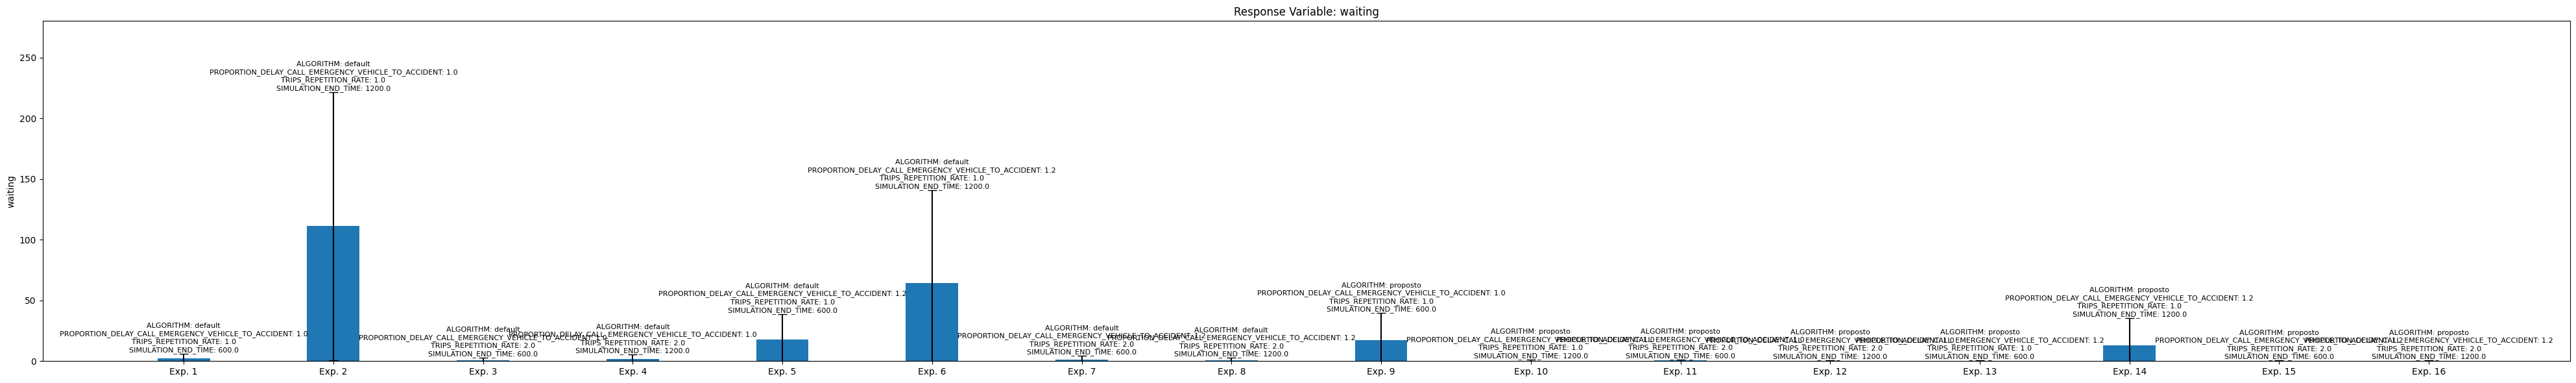

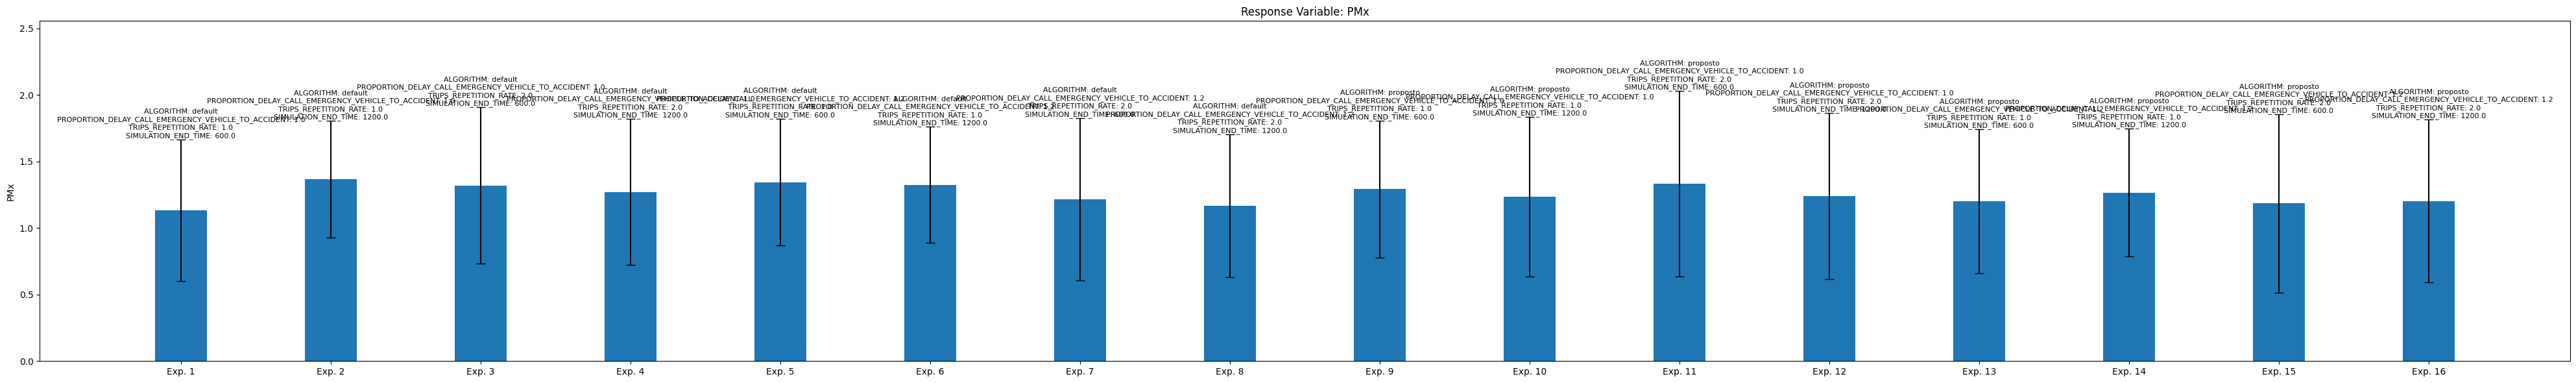

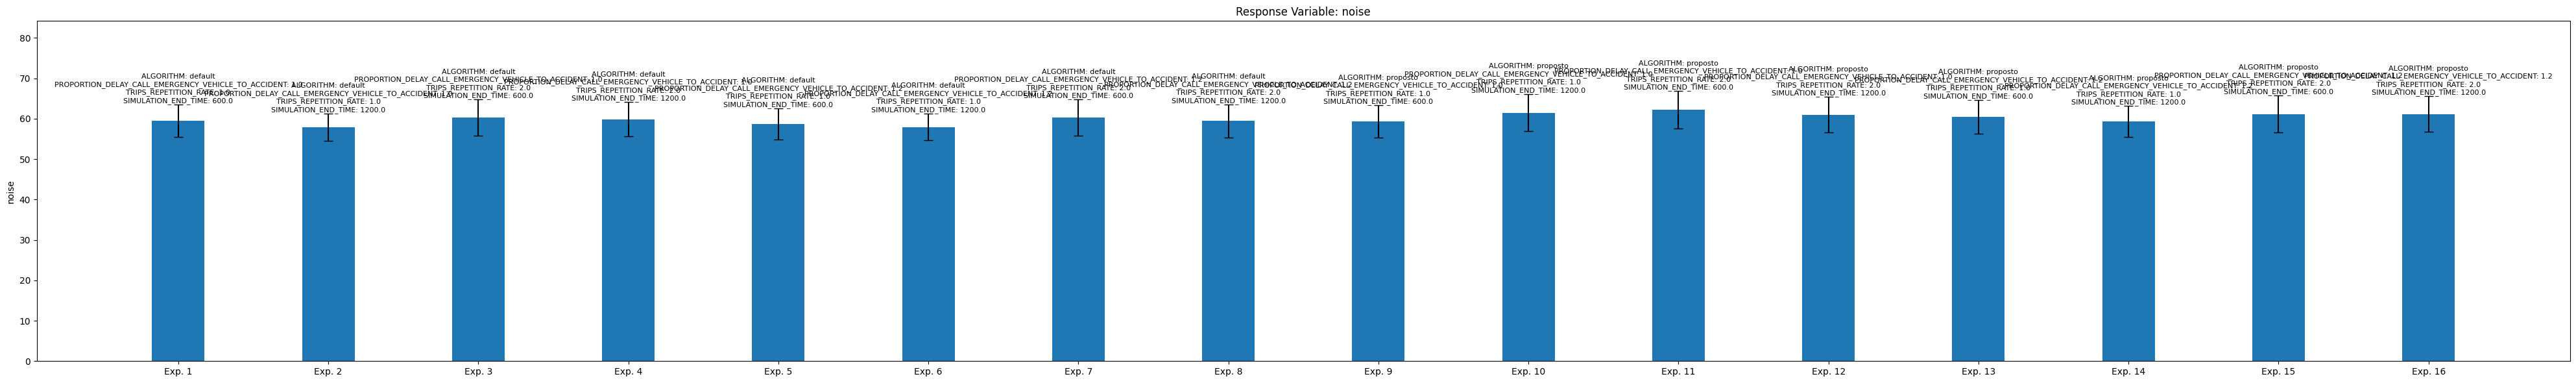

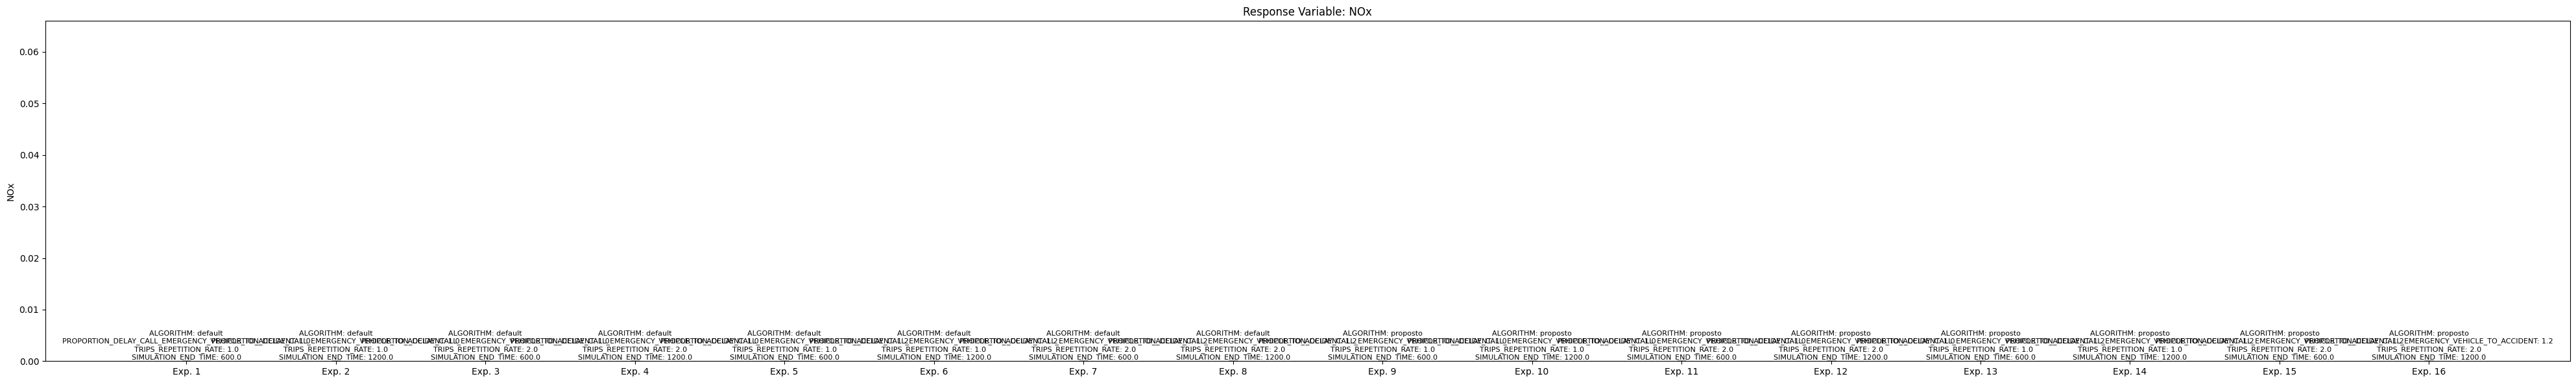

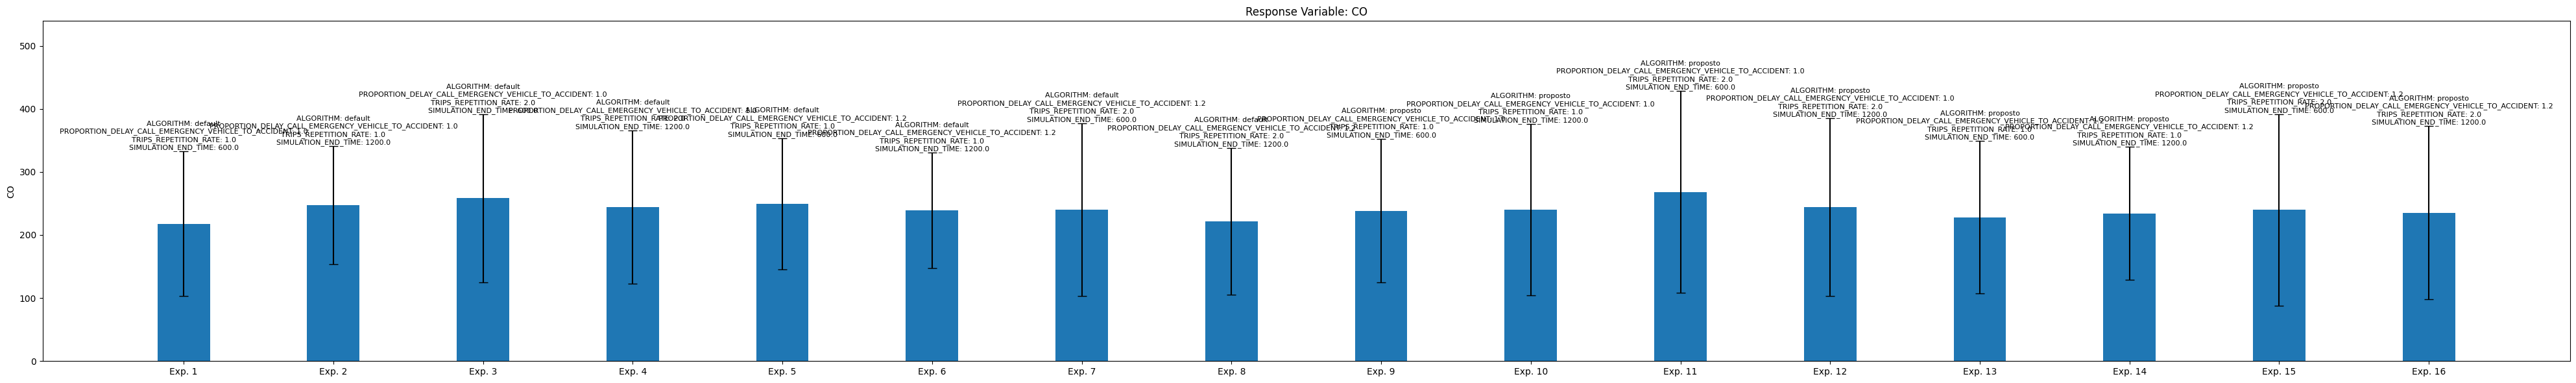

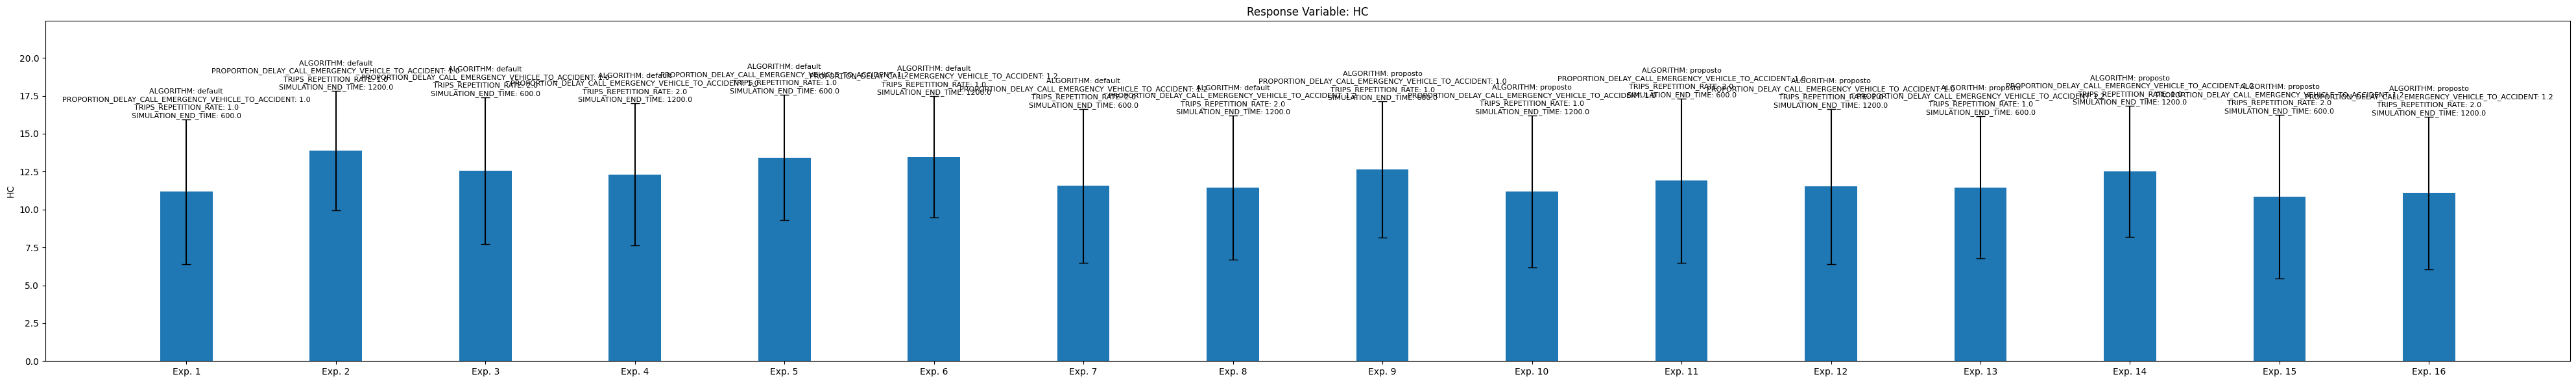

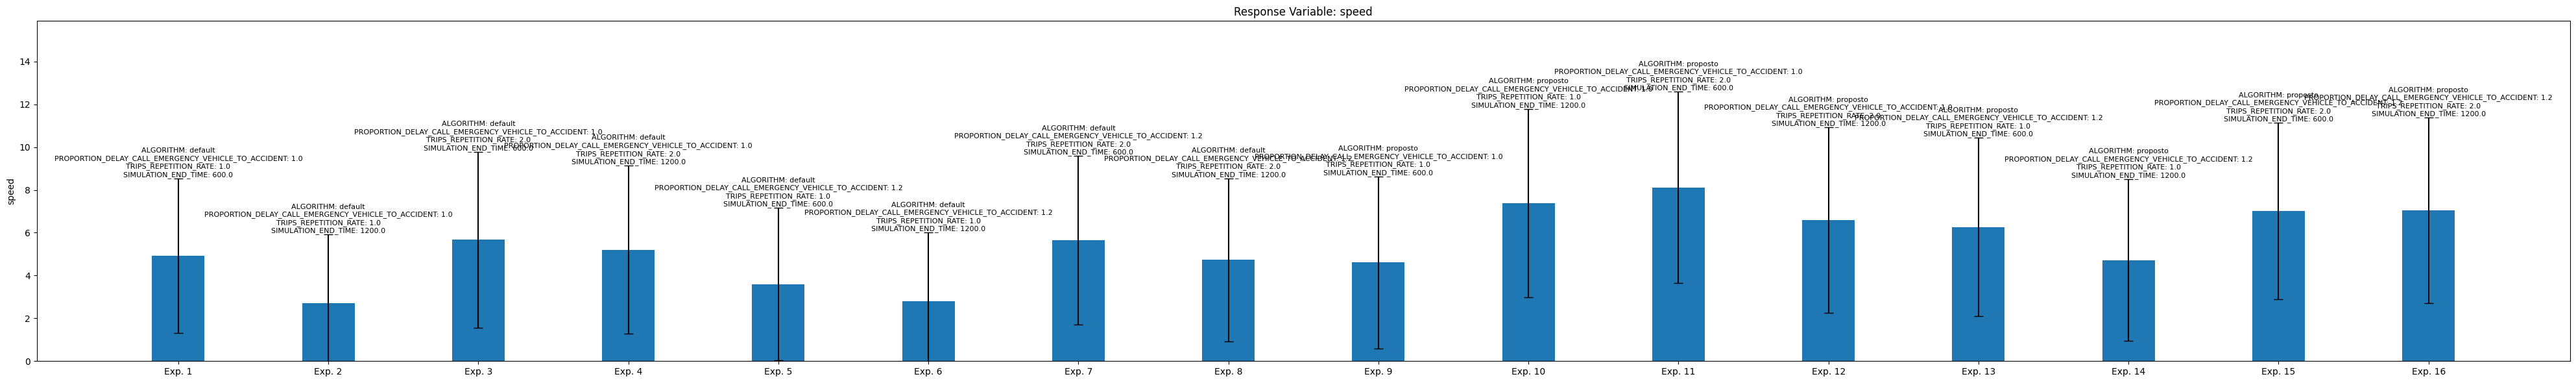

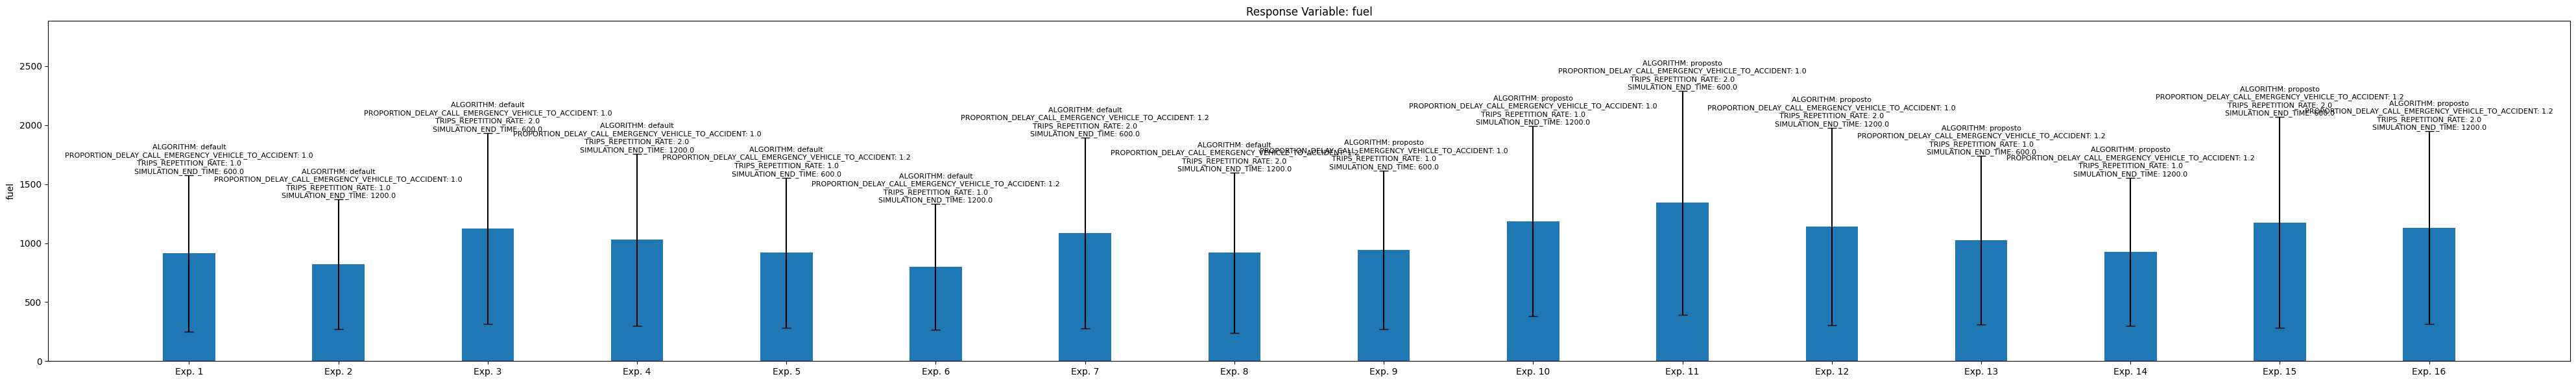

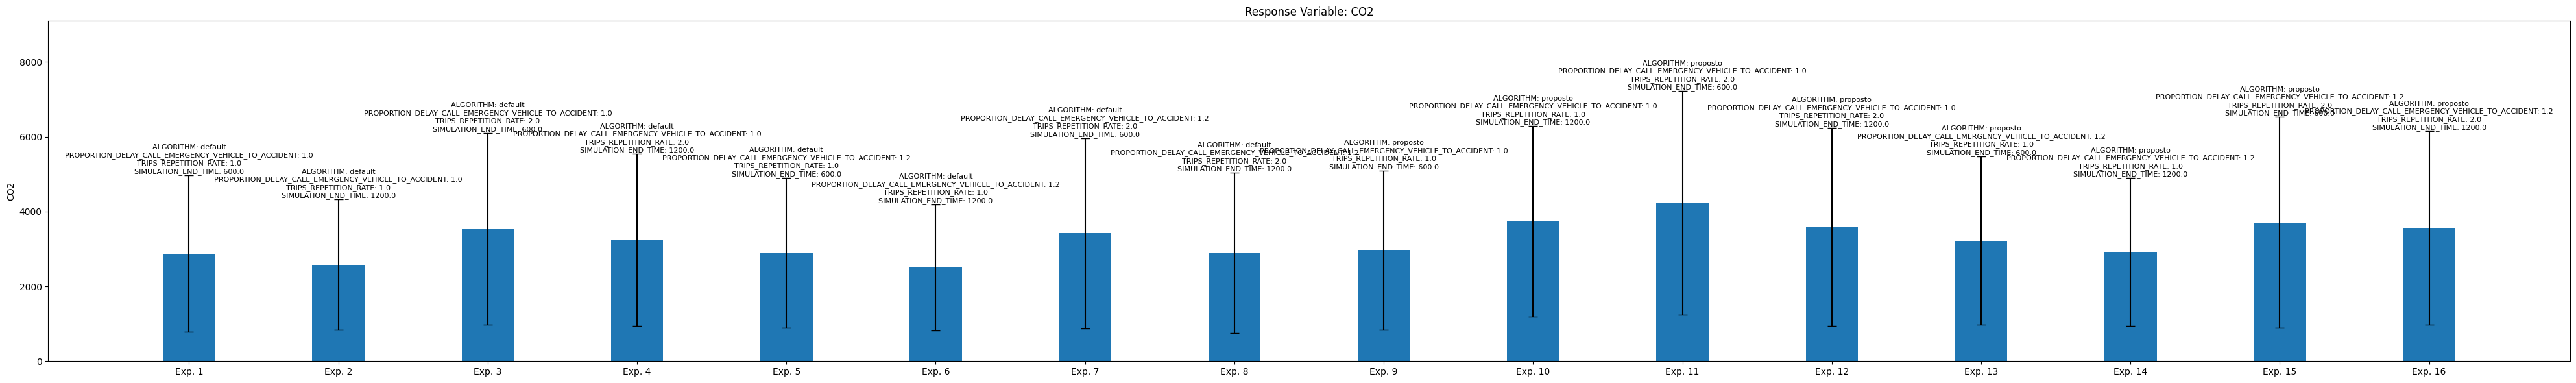

In [30]:
n_cols = 4
# Adjusting the bar width, if necessary
width = 0.35

for var_name in response_vars_names:
    # Increasing the chart height to accommodate labels
    plt.figure(figsize=(10 * n_cols, 6))  # Increasing the second value in figsize to increase the chart height
    
    n_experiments = len(experiment_settings_real_df)  # Number of experiments
    ind = np.arange(n_experiments)  # Indices for the experiments for bar positioning
    
    # Plotting the data from the real experiment settings
    bars = plt.bar(ind, experiment_settings_real_df[var_name],yerr=experiment_settings_real_df[var_name+"_err"],capsize=5,width= width, label='Experiments')
    # for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
    # plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
    
    plt.title(f'Response Variable: {var_name}')  # Chart title
    plt.ylabel(var_name)  # Y-axis label
    
    # Generating labels for each bar based on factor combinations
    exp_labels = ['Exp. ' + str(exp) for exp in experiment_settings_real_df['Exp']]
    plt.xticks(ind, exp_labels)
    
    # Adding labels above bars to show factor combinations
    for bar, label in zip(bars, experiment_settings_real_df.to_dict('records')):
        height = bar.get_height()
        comb_label = '\n'.join([f"{k}: {v}" for k, v in label.items() if k in factor_names])
        height_err_plus = label[var_name+"_err"]
        plt.text(bar.get_x() + bar.get_width() / 2, height+height_err_plus, comb_label, ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Adjusting the Y-axis limits to ensure labels fit without being cut off
    plt.ylim(0, plt.ylim()[1] * 1.2)  # Increases the upper limit of the Y-axis by 20%

    plt.tight_layout()
    plt.savefig('../plot/Emission_Emergency_Vehicle_Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.show()
